In [11]:
# Import dependencies

import numpy as np
import pandas as pd

import os

%load_ext autoreload
%autoreload 2

SEED = 42
np.random.seed(SEED)

SLIDING_WINDOW_SIZE = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Load data
import helpers

GROUPING_FEATURE = "datetime_key"
LABEL = "activity"
FEATURES = ["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"]

data_path = os.path.join('dataset', 'dataset_preprocessed.csv')
dataframe = pd.read_csv(data_path)
dfs = [v for _, v in dataframe.groupby(GROUPING_FEATURE)]

tuples = []

for df in dfs:
    tuples.append((df, df[LABEL].iloc[0]))
  
x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE)

print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (17680, 10, 6)
Shape of output vector is (17680,)


In [13]:
# Split data
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (14144, 10, 6)
Shape of y_train is (14144,)
Shape of raw_x_test is (3536, 10, 6)
Shape of y_test is (3536,)


In [14]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (14144, 80)
Shape of testing feature vector is (3536, 80)


Epoch 0 Loss 0.7278725504875183
Epoch 100 Loss 0.4104107916355133
Epoch 200 Loss 0.4017793834209442
Epoch 300 Loss 0.39562565088272095
Epoch 400 Loss 0.39148005843162537
Epoch 500 Loss 0.3882427513599396
Epoch 600 Loss 0.3855226933956146
Epoch 700 Loss 0.383377343416214
Epoch 800 Loss 0.38189998269081116
Epoch 900 Loss 0.3803883492946625
Epoch 1000 Loss 0.3792862594127655
Epoch 1100 Loss 0.3781636655330658
Epoch 1200 Loss 0.3770948350429535
Epoch 1300 Loss 0.37622955441474915
Epoch 1400 Loss 0.3755281865596771
Accuracy on training set is 0.9404694570135747


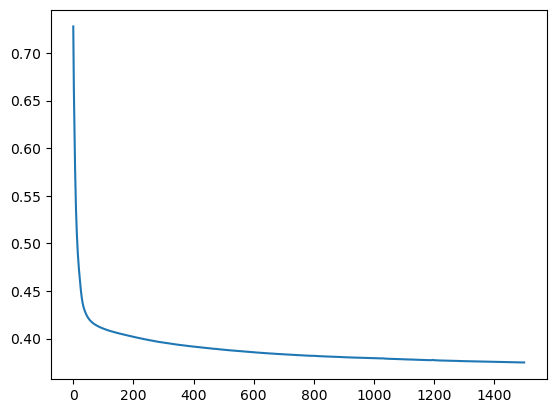

In [15]:
import torch
import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")
        
model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

In [16]:
# Evaluate the model

model.eval()
y_pred = model(torch.tensor(x_test).float())
y_pred = torch.argmax(y_pred, dim=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

# confusion_matrix(y_test, y_pred)
# display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(6))

# display.plot()


Accuracy on testing set is 0.9086538461538461
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1782
           1       0.91      0.91      0.91      1754

    accuracy                           0.91      3536
   macro avg       0.91      0.91      0.91      3536
weighted avg       0.91      0.91      0.91      3536



In [17]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {0.056127917021512985,0.058638859540224075,-0.021627407521009445,0.12577512860298157,-0.014692065306007862,-0.08022449165582657,-0.051554206758737564,0.06986711919307709,-0.08545131236314774,0.1447964757680893,0.15799900889396667,-0.05676404386758804,0.07523787766695023,0.2026682049036026,-0.07984934002161026,-0.07555180042982101,-0.18355855345726013,0.06521247327327728,-0.11716413497924805,0.14375552535057068,-0.011854853481054306,0.08781785517930984,0.10347481817007065,-0.03284139186143875,-0.21080030500888824,-0.14340904355049133,-0.12112683802843094,-0.06395059823989868,0.12967316806316376,-0.070884108543396,-0.06886376440525055,0.030610714107751846,-0.10037969797849655,-0.0541708879172802,-0.17929498851299286,-0.022584961727261543,-0.017738070338964462,-0.12919719517230988,0.09829466789960861,-0.03763505816459656,-0.038010451942682266,0.09953638911247253,0.15678121149539948,0.03336140513420105,-0.0465073436498642,0.0621

In [18]:
# Generate test cases for HLS

import random

random.seed(SEED)

TEST_CASES = 100

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)

pred_output = np.argmax(model(torch.tensor(test_cases).float()).detach().numpy(), axis=1)

test_cases_str = "float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {"
pred_output_str = "int test_output[TEST_CASES_NUMBER] = {"

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ","
for output in pred_output:
    pred_output_str += str(output) + ","

test_cases_str += "};\n"
pred_output_str += "};\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {-2.7372,3.1261,0.42388333333333333,1.7550698641522953,1.8055324168602829,2.2382277520395464,7.230499999999999,88.05330411999998,-1.6302,2.0092,0.5777333333333333,1.1993421789557068,1.331239071942627,1.1647844950891135,4.431582186984689,42.8034652,-1.501,0.2285,-0.5963499999999999,0.5967280724919852,0.8436336379021405,0.3511597499714339,3.5781,21.84606068,-2.8934,0.2876,-1.3854999999999997,1.102601064150886,1.7706889497217366,0.6594000000000002,8.313,91.20649710000002,-0.1202,1.3842,0.55355,0.6061201991629493,0.8208527872483186,0.761451108082456,3.3213,22.863907819999994,-1.881,1.7088,0.05298333333333335,1.2900895336069595,1.2911770747396862,0.31789999999999985,5.9425,47.715671619999995,-1.1195,0.1587,-0.3514666666666666,0.5568760324843901,0.6585132749864145,0.6979209983945172,3.0307999999999997,14.621908239999996,-1.7209,0.0288,-0.85595,0.7231337606787096,1.1205234662127042,1.1679548835464493,5.1357,36.745054460000006,-0.7783,2.7267,0

In [ ]:
# Generate single test case for pynq testing

TEST_CASES = 1

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)

pred_output = np.argmax(
    model(torch.tensor(test_cases).float()).detach().numpy(), axis=1
)

test_cases_str = "test_input = ["
pred_output_str = "test_output = ["

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ", "
for output in pred_output:
    pred_output_str += str(output) + ", "

test_cases_str += "]\n"
pred_output_str += "]\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

test_input = [-0.9784,1.5996,0.1449,0.7882957609087256,0.8015024745231087,0.8694,2.8067088751774736,13.684831459999998,-2.8111,2.3834,-0.17400000000000002,1.6365135878853354,1.645737744397124,0.6199581356833701,6.131031310472977,59.53040501999999,-0.7899,1.3327,0.1562333333333333,0.745251026314102,0.7614512109562022,0.9374000000000001,2.487,13.96848692,-1.5173,2.7335,0.11486666666666667,1.7976994768005272,1.801365526482618,0.6892000000000003,6.237870916426533,59.250358179999985,-0.7963,0.9241,0.05626666666666668,0.5441787379978098,0.5470799179888316,0.3376,2.0648212707157003,6.063262119999999,-2.8397,2.459,-0.026383333333333352,1.7797403662862987,1.7799359122357936,0.1583000000000001,6.580397371739794,70.48640218,-1.3872,1.0852,0.03573333333333332,0.8472231635696045,0.8479763911807922,0.21440000000000015,2.941096945018984,17.06165696,-1.5651,3.5092,0.5946666666666666,1.7736705938689843,1.8707046319502179,2.2534,6.50736472544762,71.89586253999998,-0.8899,0.797,0.03164999999999998,0.5664